In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import scipy
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha
import ROOT
import xml.etree.ElementTree as ET


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


In [2]:
def readNumEvents(file):
    """
    Moderately efficent way to get the number of events stored in file.
    """
    
    with pylhe._extract_fileobj(file) as fileobj:
        nevts = sum(element.tag == "event" for event, element in ET.iterparse(fileobj, events=["end"]))
    return nevts

In [3]:
inputFiles = {'dmsimp_spin1': '/home/camila/MG5/dmsimp_test4/Events/run_02/unweighted_events.lhe.gz',
              '2mdm_spin1': '/home/camila/MG5/2mdm_nlo_spin1/Events/run_02/unweighted_events.lhe.gz'
              }

In [4]:
events = {}
nevents = {}
for label,f in inputFiles.items():   
    events[label] = pylhe.read_lhe_with_attributes(f)
    nevents[label] = readNumEvents(f)


In [5]:
parameters = {}
for label,file in inputFiles.items():
    banner = sorted(glob.glob(os.path.dirname(file)+'/*banner.txt'),key=os.path.getmtime,reverse=True)
    if len(banner) == 0:
        print('Banner not found for %s' %label)
    elif len(banner) > 1:        
        print('\n%i banner files found for %s. Using %s' 
              %(len(banner),label,os.path.basename(banner[0])))
    banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    
    if 9900032 in pars.blocks['MASS']:
        model = '2mdm'        
        mZp = pars.blocks['MASS'][9900032] # Z prime mass
        
    elif 55 in pars.blocks['MASS']:
        model = 'dmsimp'
        mZp = pars.blocks['MASS'][55] # Z prime mass
        
    
    if model == '2mdm':
        mH2 = pars.blocks['BLINPUTS'][2] # dark Higgs mass
        mChi = pars.blocks['MASS'][9000006] # DM mass
        sTheta = pars.blocks['BLINPUTS'][3] # sin theta
        gchi = pars.blocks['ZPRIME'][1] # coupling of mediators to DM
        gq = pars.blocks['ZPRIME'][2] # coupling of mediators to SM
    elif model == 'dmsimp':
        mH2 = np.nan # dark Higgs mass
        mChi = pars.blocks['MASS'][52] # DM mass
        sTheta = 0
        gchi = pars.blocks['DMINPUTS'][3] # coupling of mediators to DM
        gq = pars.blocks['DMINPUTS'][6] # coupling of mediators to SM  
        

    
        
    parameters[label] = {'mZp' : mZp, 'mDM' : mChi, 'mH2' : mH2,
                         'gq' : gq, 'sTheta' : sTheta, 'gx' : gchi}
    print(label,': mZp = %1.2f GeV, mH2 = %1.2f GeV, mDM = %1.2f GeV' %(mZp,mH2,mChi))

dmsimp_spin1 : mZp = 2000.00 GeV, mH2 = nan GeV, mDM = 100.00 GeV
2mdm_spin1 : mZp = 2000.00 GeV, mH2 = 300.00 GeV, mDM = 65.00 GeV


In [6]:
## jets
pTj1min = 25.
pTjmin = 25.
# etamax = 2.4
# ## MET
minMET = 25.
# ## Electrons
# pTmin_el = 10.
# etamax_el = 2.5
# nMax_el = 0
# ## Muons
# pTmin_mu = 10.
# etamax_mu = 2.4
# nMax_mu = 0

In [7]:
## jets
pTj1min = 25.
pTjmin = 25.
etamax = 5.
# ## MET
minMET = 250.
# ## Electrons
# pTmin_el = 10.
# etamax_el = 2.5
# nMax_el = 0
# ## Muons
# pTmin_mu = 10.
# etamax_mu = 2.4
# nMax_mu = 0

In [8]:
pTj1 = {label : np.array([]) for label in inputFiles}
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
njets = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0 for label in inputFiles}
# negweight = {label : np.array([]) for label in inputFiles}

for label,evts in events.items():
   
    nevts = nevents[label]
    parameters[label]['Events'] = nevts
    
    for event in evts:

        particles = event.particles
       
       
        jets = [p for p in particles if abs(p.id) in [1,2,3,4,5,21] and p.status == 1]
        dm = [p for p in particles if abs(p.id) in [9000006, 52] and p.status == 1]
#         electrons = [p for p in particles if abs(p.id) in [11] and p.status == 1]
#         muons = [p for p in particles if abs(p.id) in [13] and p.status == 1]
        
#         if len(med) != 1:
#             continue
        if len(dm) != 2:
            continue
            
        weight = event.eventinfo.weight/nevts
            
#         if weight < 0:
#             negw = weight
#             negweight[label] += negw
#             negweight[label] = np.append(negweight[label], negw)
#             continue
            
        totalweight[label] += weight
            
        # Filter jets
        jetList = []
        for j in jets:
            pT = np.sqrt(j.px**2+j.py**2)
            p = np.sqrt(j.px**2+j.py**2+j.pz**2)
            pL = j.pz
            eta = 0.5*np.log((p+pL)/(p-pL))
            
            if pT < pTjmin:
                continue
            if np.abs(eta) > etamax:
                continue
            jetList.append(j)
        jetList = sorted(jetList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)          
        
            
        # Filter electrons
#         electronList = []
#         for el in electrons:
#             pT = np.sqrt(el.px**2+el.py**2)
#             p = np.sqrt(el.px**2+el.py**2+el.pz**2)
#             pL = el.pz
#             eta = 0.5*np.log((p+pL)/(p-pL))
            
# #             if pT < pTmin_el:
# #                 continue
# #             if np.abs(eta) > etamax_el:
# #                 continue
#             electronList.append(el)
#         electronList = sorted(electronList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)                                    
        
        # Filter muons
#         muonList = []
#         for mu in muons:
#             pT = np.sqrt(mu.px**2+mu.py**2)
#             p = np.sqrt(mu.px**2+mu.py**2+mu.pz**2)
#             pL = mu.pz
#             eta = 0.5*np.log((p+pL)/(p-pL))
            
#             if pT < pTmin_mu:
#                 continue
#             if np.abs(eta) > etamax_mu:
#                 continue
#             muonList.append(mu)
#         muonList = sorted(muonList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)                                            
              
        # Compute MET
#         MET = np.sqrt((med[0].px)**2 + (med[0].py)**2)
        MET = np.sqrt((dm[0].px+dm[1].px)**2 + (dm[0].py+dm[1].py)**2)
        
        # Compute deltaPhi
#         if len(jetList) > 0:
#             phij1 = np.arctan2(jetList[0].py,jetList[0].px)
# #             phiMET = np.arctan2((med[0].py),(med[0].px))
#             phiMET = np.arctan2((dm[0].py+dm[1].py),(dm[0].px+dm[1].px))
#             deltaPhi = np.abs(phij1-phiMET)
#         else:
#             deltaPhi = 0.0
        
#         #Apply cuts:
#         if len(electronList) > 0:
#             continue
#         if len(muonList) > 0:
#             continue
        if len(jetList) == 0:
            continue
        
        pT1 = np.sqrt(jetList[0].px**2+jetList[0].py**2)
        if MET < minMET:
            continue
#         if pT1 < pTj1min:
#             continue
#         if deltaPhi < 0.5:
#             continue
        
        # Store relevant data        
        njets[label] = np.append(njets[label],len(jets))
        pTj1[label] = np.append(pTj1[label],pT1)
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label],MET)
        

In [9]:
# for label in weights:
#     frac = np.array(len(negweight[label]))/nevents[label]*100
#     print(label, 'Fraction of negative events: %1.2f%%' 
#           %frac)

In [10]:
for label, w in weights.items():
    print(len(weights[label]))

3911
14740


In [11]:
nevents

{'dmsimp_spin1': 50000, '2mdm_spin1': 50000}

In [12]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb' %w)
colors = {label : sns.color_palette('deep', n_colors=16)[i] for i,label in enumerate(weights.keys())}    

dmsimp_spin1 total cross-section = 2.575e-01 pb
2mdm_spin1 total cross-section = 4.416e-02 pb


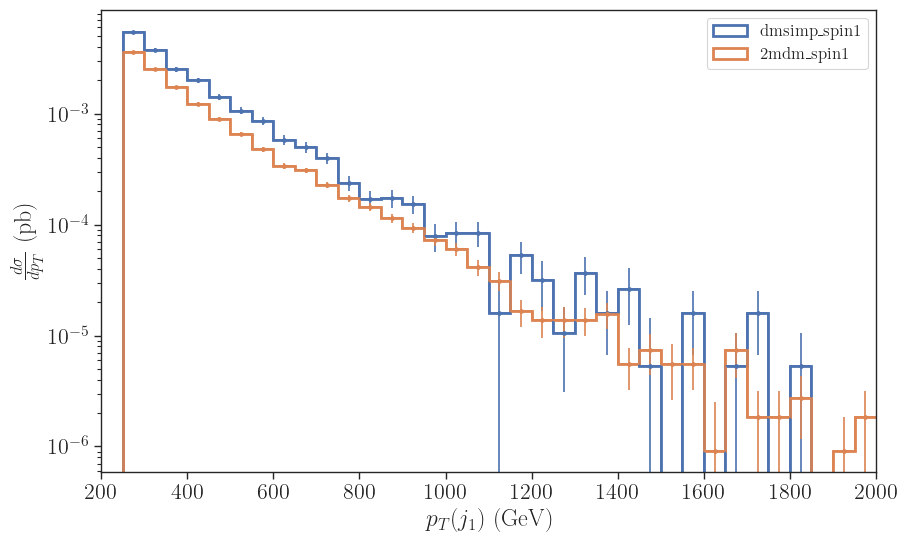

In [13]:
fig = plt.figure(figsize=(10,6))
for label,pt in pTj1.items():
#     if label in ['scalar_run03']:
    binc,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],
                               weights=weights[label],linewidth=2, density=False)
    errorc2,_ = np.histogram(pt,bins=binEdges,weights=weights[label]**2)
    errorc = np.sqrt(errorc2)
    binCenter = (binEdges[0:-1]+binEdges[1:])/2.
    plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
                 drawstyle = 'steps-mid',color=colors[label])

    
plt.yscale('log')
# plt.ylim(1e-9,1e-3)
plt.xlabel(r'$p_T(j_1)$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{dp_{T}}$ (pb)')
plt.xlim(200,2000)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

/tmp/ipykernel_621823/2874265850.py:32: RuntimeWarning: divide by zero encountered in divide
  ratio = k*bincSc/bincPs
/tmp/ipykernel_621823/2874265850.py:32: RuntimeWarning: invalid value encountered in divide
  ratio = k*bincSc/bincPs
/tmp/ipykernel_621823/2874265850.py:33: RuntimeWarning: invalid value encountered in multiply
  ratioErr = np.sqrt(errorSc**2 + ratio**2 * errorPs**2)/bincPs


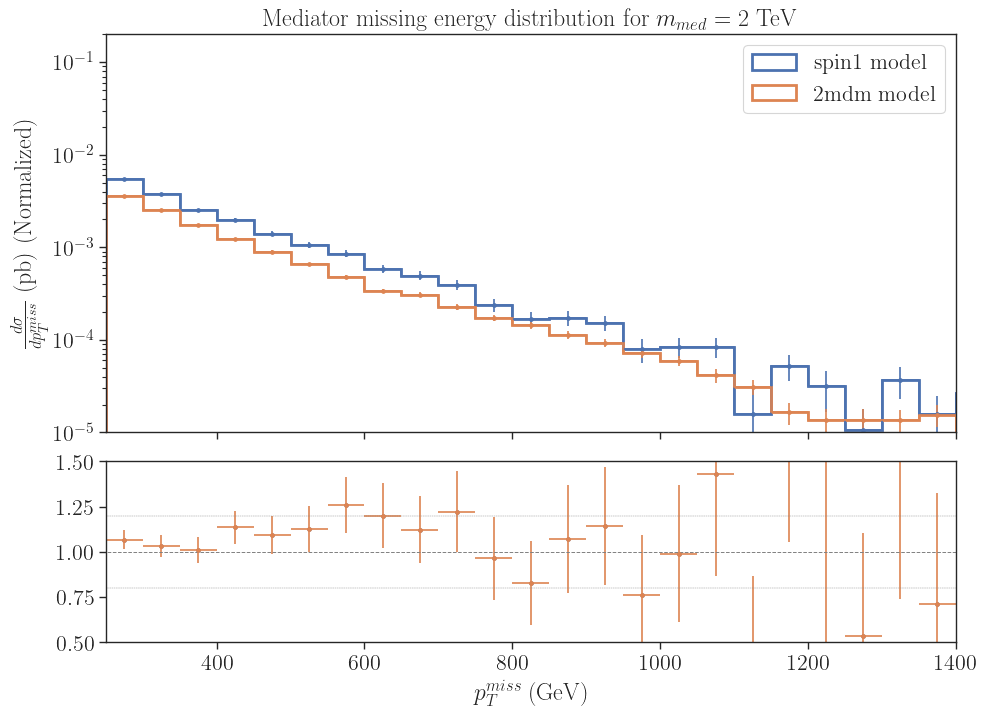

In [23]:
figs, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2.2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

k=0.7
# k = totalweight['dmsimp_spin1']/totalweight['2mdm_spin1']

for label,metPts in met.items():
    if label in ['dmsimp_spin1']:
        bincSc,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'%s model' %(label.split('_')[1]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2)
        binCenter = (binEdges[0:-1]+binEdges[1:])/2.
        errorSc2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorSc = np.sqrt(errorSc2)
        errorSc[errorSc<0] = 0
        ax[0].errorbar(binCenter,bincSc,yerr = errorSc, marker = '.', drawstyle = 'steps-mid',color=colors[label])

    
    if label in ['2mdm_spin1']:
        bincPs,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'%s model' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2)
        errorPs2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorPs = np.sqrt(errorPs2)
        errorPs[errorPs<0] = 0
        
        ax[0].errorbar(binCenter,bincPs,yerr = errorPs, marker = '.', drawstyle = 'steps-mid',color=colors[label])

        
ratio = k*bincSc/bincPs
ratioErr = np.sqrt(errorSc**2 + ratio**2 * errorPs**2)/bincPs
binCenter = (binEdges[0:-1]+binEdges[1:])/2.
errorh = (np.diff(binEdges+[2000.])/2).tolist()

ax[1].scatter(binCenter, ratio, marker='.')
ax[1].errorbar(binCenter,ratio,xerr = errorh, yerr = ratioErr, fmt='.', color=colors['2mdm_spin1'])
ax[1].hlines(y=1, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.7)
ax[1].hlines(y=1.2, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
ax[1].hlines(y=0.8, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)

        
ax[0].set_yscale('log')
ax[0].set_ylim(1e-5,2e-1)
ax[0].set_ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb) (Normalized)')
ax[0].set_xlim(250,1400)
ax[0].legend(loc='upper right')
ax[0].set_title(r'Mediator missing energy distribution for $m_{med} = 2$ TeV')


ax[1].set_ylim(0.5,1.5)
ax[1].set_xlabel(r'$p_T^{miss}$ (GeV)')

# plt.savefig('plot-s-ps-bias.png')
plt.show()